In [414]:
# Imports
import os
import dill
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

from sklearn.feature_selection import SelectFromModel

In [364]:
# Load dataset
data = pd.read_csv("../data/02_engineered_data.csv")

In [365]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16048 entries, 0 to 16047
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   WEIGHT                   16048 non-null  float64
 1   GENDER                   16048 non-null  object 
 2   NUMBER_OF_CHILDREN       16048 non-null  int64  
 3   AGE                      16048 non-null  int64  
 4   HOUSEHOLD_SIZE           16048 non-null  int64  
 5   TV_TOTAL                 16048 non-null  float64
 6   FLYERS                   16048 non-null  float64
 7   PRINT_TOTAL              16048 non-null  float64
 8   ONLINE_VIDEO             16048 non-null  float64
 9   ONLINE_DISPLAY           16048 non-null  float64
 10  ONLINE_TOTAL             16048 non-null  float64
 11  TIKTOK                   16048 non-null  float64
 12  YOUTUBE_TOTAL            16048 non-null  float64
 13  YOUTUBE_MOBILE           16048 non-null  float64
 14  YOUTUBE_DESKTOP       

## 1. Data Pre-Proccessing

In [366]:
# Get dummies for gender
data = pd.get_dummies(data, columns=['GENDER'], drop_first=True)  # Drops one category to avoid multicollinearity

In [367]:
train_features = [
    # 'WEIGHT',
    'GENDER_MALE',
    'GENDER_UNKNOWN',
    'NUMBER_OF_CHILDREN',
    'AGE',
    'HOUSEHOLD_SIZE',
    'TV_TOTAL',
    'FLYERS',
    'PRINT_TOTAL',
    'ONLINE_VIDEO',
    'ONLINE_DISPLAY',
    'ONLINE_TOTAL',
    'TIKTOK',
    'YOUTUBE_TOTAL',
    'YOUTUBE_MOBILE',
    'YOUTUBE_DESKTOP',
    'YOUTUBE_TABLET',
    'YOUTUBE_CTV',
    'PINTEREST',
    # 'PURCHASE',
    'OUTLIER_SCORE',
    'TOTAL_MEDIA_EXPOSURE',
    'DIGITAL_MEDIA_TOTAL',
    'TRADITIONAL_MEDIA_TOTAL',
    # 'AGE_GROUP',
    'HEAVY_MEDIA_USER'
]


In [368]:
X = data[train_features]
y = data['PURCHASE']  # Target variable
weights = data['WEIGHT']  # Store weights separately

# Shape check
X.shape, y.shape, weights.shape

((16048, 23), (16048,), (16048,))

### Train/Test split

In [369]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, weights, test_size=0.2, random_state=42)

### Data Scaling
- 
- 
- Scaling the weights should not be required since they adjust the loss function on a per-observation basis and it shouldn't matter if the values vary significantly as long as they are consistent in their relative importance.

In [370]:
# List of columns to not scale (categorical and binary columns)
exclude_columns = ['TARGET_GROUP', 'OUTLIER_SCORE', 'HEAVY_MEDIA_USER', 'ENGAGED_VIDEO_USER']

# List of all columns in the dataframe
all_columns = X_train.columns.tolist()

# Columns to scale: all columns except the ones to exclude
columns_to_scale = [col for col in all_columns if col not in exclude_columns]

# Initialize scaler
scaler = StandardScaler()

# Scale specific features in train and test data
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[columns_to_scale] = scaler.fit_transform(X_train_scaled[columns_to_scale])
X_test_scaled[columns_to_scale] = scaler.transform(X_test_scaled[columns_to_scale])

## 2. Preliminary Model Selection
Let's try and run a cross validation on several models that I expect will do well on this type of dataset.

Metric of choice will be ROC_AUC

In [426]:
# Pulling metric out to be easily adjustable
METRIC = "accuracy"
# METRIC = "roc_auc"

In [453]:
def model_evaluation(models: dict, X_train, y_train, w_train, metric):
    """
    This function uses Cross Validation to evaluate models' perfomence. Returns a report of the models' names and mean scores.
    """

    evaluation_report = {}
    for model_name, model in models.items():

        cv = cross_val_score(
            model, 
            X_train, 
            y_train, 
            cv=5, 
            scoring=metric, 
            # fit_params={'sample_weight': w_train},
            n_jobs=-1
        )

        evaluation_report[model_name] = cv.mean()
        
        cv_rounded = [f"{round(score * 100, 1)}%" for score in cv]
        cv_mean = f"{round(cv.mean() * 100, 1)}%"
        
        print(f"{model_name}:\n- CV {METRIC} scores: {' | '.join([item for item in cv_rounded])}\n- CV mean: {cv_mean}\n")

    return evaluation_report


# Models for preliminary testing
models = {
    'Logistic Regression': LogisticRegression(max_iter=2000, random_state=42),
    'Random Forest Classifier': RandomForestClassifier(random_state=42),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=42),
    'KNeighbors Classifier': KNeighborsClassifier(),
    'SVC': SVC(probability=True, random_state=42),
}

In [454]:
_ = model_evaluation(models, X_train_scaled, y_train, w_train, METRIC)

TypeError: got an unexpected keyword argument 'fit_params'

## Support Functions


In [439]:
def evaluate_model_performance(model, X, y, w_test):
    """
    Evaluates the model performance using weighted ROC AUC, a weighted classification report,
    and a weighted confusion matrix heatmap.

    Args:
        model: Trained model (e.g., SVC, RandomForest, etc.)
        X: Features (DataFrame or array-like)
        y: True labels (array-like)
        w_test: Sample weights corresponding to each observation in X and y
        
    Returns:
        None
    """
    # Make predictions
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]  # Probability estimates for the positive class

    # custom_threshold = 0.3
    # y_prob = (y_prob >= custom_threshold).astype(int)

    # Calculate and print the weighted ROC AUC score
    print("||---------------------------------------------------------------------")
    # metric_score = roc_auc_score(y, y_prob, sample_weight=w_test)
    metric_score = accuracy_score(y, y_pred, sample_weight=w_test)
    print(f"Weighted ROC AUC Score: {metric_score:.4f}")

    # Generate and print the weighted classification report
    print("||---------------------------------------------------------------------")
    class_report = classification_report(y, y_pred, sample_weight=w_test)
    print("\nWeighted Classification Report:\n", class_report)
    
    # Compute the weighted confusion matrix
    print("||---------------------------------------------------------------------")
    cm = confusion_matrix(y, y_pred, sample_weight=w_test)
    
    # Plot the weighted confusion matrix as a heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', 
                xticklabels=['Pred: No', 'Pred: Yes'], 
                yticklabels=['True: No', 'True: Yes'], cbar=False)
    plt.title('Weighted Confusion Matrix Heatmap')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


In [402]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_precision_recall_curve(model, X, y, w_test):
    """
    Plots the precision-recall curve and calculates the average precision score.

    Args:
        model: Trained classification model.
        X: Feature set.
        y: True labels.
        w_test: Sample weights.

    Returns:
        None
    """
    # Get predicted probabilities for the positive class
    y_scores = model.predict_proba(X)[:, 1]

    # Compute precision, recall, and thresholds
    precision, recall, _ = precision_recall_curve(y, y_scores, sample_weight=w_test)

    # Compute the Average Precision (AP) score
    avg_precision = average_precision_score(y, y_scores, sample_weight=w_test)

    # Plot the precision-recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', label=f'AP = {avg_precision:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid()
    plt.show()




### Save/Load models

In [421]:
def save_model(model, model_name, models_folder="..\models"):
    """
    Saves a trained model to the specified folder using dill.

    Args:
        model: The trained model to save.
        model_name (str): The name of the file (e.g., "best_model.pkl").
        models_folder (str): The folder in which to save the model (default is "models").

    Returns:
        str: The full path to the saved model file.
    """
    # Create the models folder if it doesn't exist.
    if not os.path.exists(models_folder):
        os.makedirs(models_folder)
    
    # Construct the full file path.
    model_path = os.path.join(models_folder, model_name)
    
    # Save the model using dill.
    with open(model_path, 'wb') as file:
        dill.dump(model, file)
    print(f"Model saved to: {model_path}")
    
    # return model_path

In [416]:
def load_model(model_name, models_folder="..\models"):
    """
    Loads a model from the specified folder using dill.

    Args:
        model_name (str): The name of the model file to load (e.g., "best_model.pkl").
        models_folder (str): The folder from which to load the model (default is "models").

    Returns:
        The loaded model.
    """
    # Construct the full file path.
    model_path = os.path.join(models_folder, model_name)
    
    # Check if the model file exists.
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found: {model_path}")
    
    # Load and return the model.
    with open(model_path, 'rb') as file:
        model = dill.load(file)
    print(f"Model loaded from: {model_path}")
    
    return model

## Model Tuning

### 1. Logistic Regression

Let's start by attempting toi squeeze a bit more performance out of lr. It's a simplistic model, quick to tune and will give me a general idea what I can expect with this dataset. Let's start by passing the weights.

In [441]:
# Initialize the model
lr = LogisticRegression(max_iter=1000, random_state=42)

# Fit the model with sample weights
lr.fit(X_train_scaled, y_train, sample_weight=w_train)

# Predict probabilities (probability of Purchase = 1)
y_pred_proba = lr.predict_proba(X_test_scaled)[:, 1]  # Probability of positive class (Purchase = 1)

# Evaluate model (using ROC AUC score)
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba, sample_weight=w_test))

# from sklearn.metrics import accuracy_score
# weighted_accuracy = accuracy_score(y_test, y_pred, sample_weight=w_test)


ROC AUC Score: 0.7223522930885292


In [430]:
# Initialize the model
lr = LogisticRegression(max_iter=1000, random_state=42)

# Fit the model with sample weights
lr.fit(X_train_scaled, y_train, sample_weight=w_train)

# Predict labels
y_pred = lr.predict(X_test_scaled)

# Evaluate model using weighted accuracy
weighted_accuracy = accuracy_score(y_test, y_pred, sample_weight=w_test)
print(f"Weighted Accuracy: {weighted_accuracy}")


Weighted Accuracy: 0.6815848850526467


The addition of sample weights has decreased the score

In [436]:
# Define hyperparameter grid for tuning
param_grid = {
    'max_iter' : [4, 10, 50, 100],
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['liblinear', 'saga'],  # Optimizer
    'penalty': ['l1', 'l2'],  # Regularization type
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    scoring=METRIC,  # Use ROC AUC as the evaluation metric
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available processors
)

# Fit the model using training data and sample weights
grid_search.fit(X_train_scaled, y_train, sample_weight=w_train)

# Get the best model from GridSearchCV
best_lr = grid_search.best_estimator_

# Predict probabilities (probability of Purchase = 1) on test set
y_pred_proba = best_lr.predict_proba(X_test_scaled)[:, 1]

# # Evaluate the best model using ROC AUC score
# roc_auc = roc_auc_score(y_test, y_pred_proba, sample_weight=w_test)
# print("Best Model ROC AUC Score:", roc_auc)

# Evaluate model using weighted accuracy
weighted_accuracy = accuracy_score(y_test, y_pred, sample_weight=w_test)
print(f"Weighted Accuracy: {weighted_accuracy}")

# Display best hyperparameters found by GridSearchCV
print("Best Hyperparameters:", grid_search.best_params_)

Weighted Accuracy: 0.6815848850526467
Best Hyperparameters: {'C': 0.1, 'max_iter': 10, 'penalty': 'l1', 'solver': 'liblinear'}


c:\Users\ksbon\Desktop\Programing\NIQ-Task\venv\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


||---------------------------------------------------------------------
Weighted ROC AUC Score: 0.6820
||---------------------------------------------------------------------

Weighted Classification Report:
               precision    recall  f1-score   support

       False       0.68      0.77      0.72 8922994.970000016
        True       0.69      0.58      0.63 7791340.720000001

    accuracy                           0.68 16714335.690000016
   macro avg       0.68      0.68      0.68 16714335.690000016
weighted avg       0.68      0.68      0.68 16714335.690000016

||---------------------------------------------------------------------


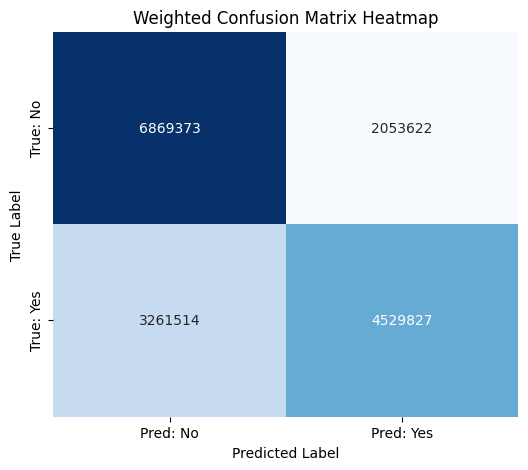

In [442]:
evaluate_model_performance(best_lr, X_test_scaled, y_test, w_test)

### Random Forrest

Random Forest is a good way of checking if dimentionality reduction is required sa the model does well even without it. If it scores better than other models it might be an argument for it.

In [443]:
# Initialize a random forest model
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)

# Define the hyperparameter grid for tuning
param_grid = {
    'n_estimators': [200, 400, 800],  # Number of trees
    'max_depth': [5, 10, 20],  # Max depth of trees
    'min_samples_split': [2, 5, 10],  # Min samples required to split an internal node
    'min_samples_leaf': [4, 8, 12],  # Min samples required to be at a leaf node
    'max_features': ['sqrt', 'log2'],  # Number of features to consider for the best split
}

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=METRIC,  # Use ROC AUC as the evaluation metric
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available processors
)

# Fit the model using training data and sample weights
grid_search.fit(X_train_scaled, y_train, sample_weight=w_train)

# Get the best model from GridSearchCV
best_rf = grid_search.best_estimator_

# Predict probabilities (probability of Purchase = 1) on test set
y_pred_proba = best_rf.predict_proba(X_test_scaled)[:, 1]

# Evaluate the best model using ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba, sample_weight=w_test)
print("Best Model ROC AUC Score:", roc_auc)

# Display best hyperparameters found by GridSearchCV
print("Best Hyperparameters:", grid_search.best_params_)

Best Model ROC AUC Score: 0.7306604795723082
Best Hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 400}


||---------------------------------------------------------------------
Weighted ROC AUC Score: 0.6980
||---------------------------------------------------------------------

Weighted Classification Report:
               precision    recall  f1-score   support

       False       0.68      0.84      0.75 8922994.970000016
        True       0.74      0.54      0.62 7791340.720000001

    accuracy                           0.70 16714335.690000016
   macro avg       0.71      0.69      0.69 16714335.690000016
weighted avg       0.71      0.70      0.69 16714335.690000016

||---------------------------------------------------------------------


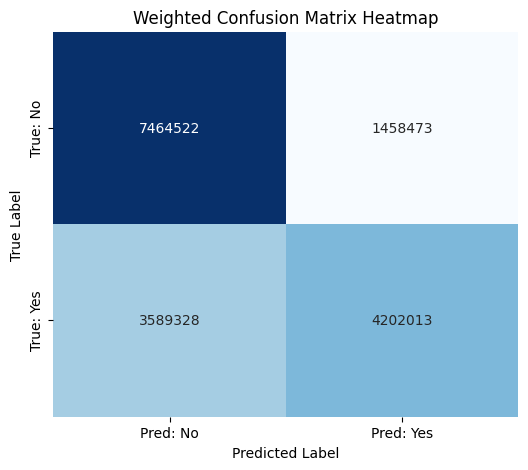

In [445]:
evaluate_model_performance(best_rf, X_test_scaled, y_test, w_test)

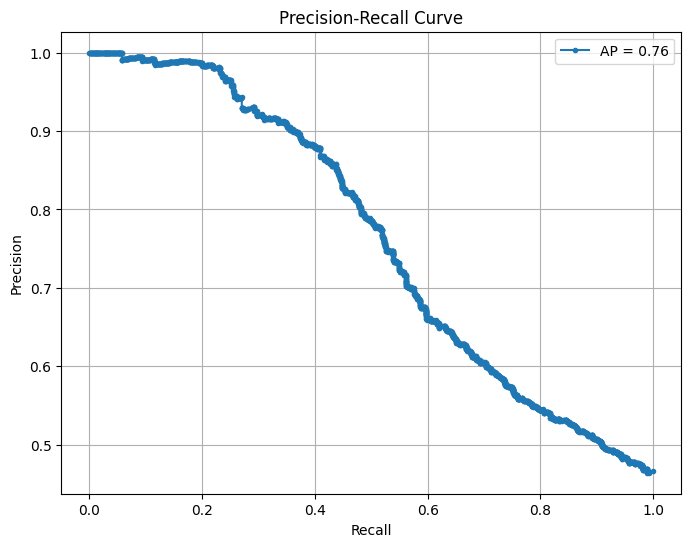

In [446]:
# Example usage:
plot_precision_recall_curve(best_rf, X_test_scaled, y_test, w_test)

In [354]:
# # Example usage:
# subgroup_feature = 'AGE'  # Replace with the column you want to analyze
# subgroup_results = evaluate_subgroup_performance(best_rf, X, y, w_test, subgroup_feature, data)
# print(subgroup_results)

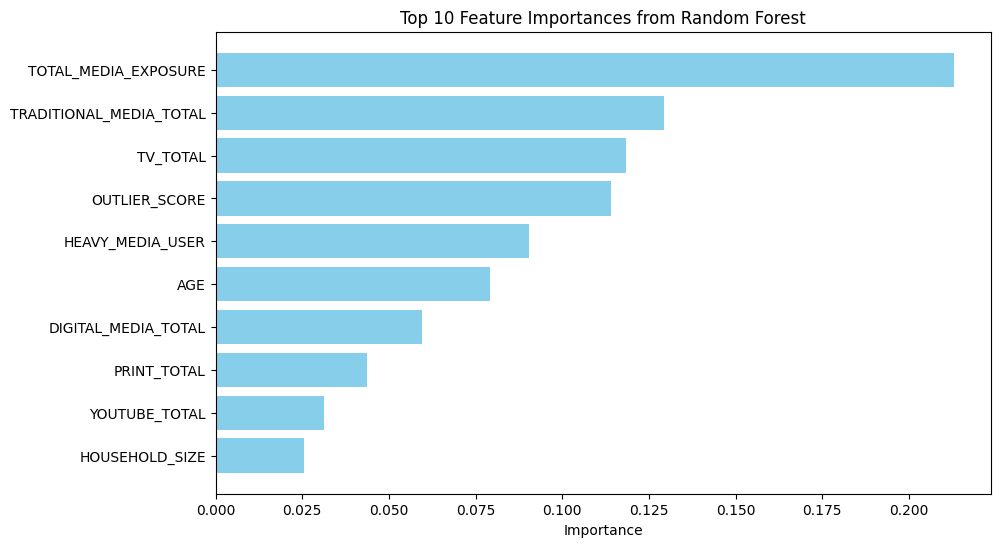

In [447]:
# Get feature importance
importance_df_rf = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_rf.feature_importances_
})

# Sort by importance
importance_df_rf = importance_df_rf.sort_values(by='Importance', ascending=False)

# print(importance_df_rf)

# Plot the top 10 most important features
plt.figure(figsize=(10, 6))
plt.barh(importance_df_rf['Feature'][:10], importance_df_rf['Importance'][:10], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances from Random Forest')
plt.gca().invert_yaxis()  # Invert the y-axis to display the most important features at the top
plt.show()

In [358]:
# # Select features with importance above a threshold (e.g., 0.01)
# selected_features = importance_df_rf[importance_df_rf["Importance"] > 0.03]["Feature"].tolist()

# # Filter dataset to keep only the most important features
# X_train_selected = X_train[selected_features]
# X_test_selected = X_test[selected_features]

# print(f"Selected Features ({len(selected_features)}): {selected_features}")

In [359]:
# # Initialize GridSearchCV with 5-fold cross-validation
# grid_search = GridSearchCV(
#     estimator=rf,
#     param_grid=param_grid,
#     scoring='roc_auc',  # Use ROC AUC as the evaluation metric
#     cv=5,  # 5-fold cross-validation
#     n_jobs=-1,  # Use all available processors
# )

# # Fit the model using training data and sample weights
# grid_search.fit(X_train_selected, y_train, sample_weight=w_train)

# # Get the best model from GridSearchCV
# best_rf = grid_search.best_estimator_

# # Predict probabilities (probability of Purchase = 1) on test set
# y_pred_proba = best_rf.predict_proba(X_test_selected)[:, 1]

# # Evaluate the best model using ROC AUC score
# roc_auc = roc_auc_score(y_test, y_pred_proba, sample_weight=w_test)
# print("Best Model ROC AUC Score:", roc_auc)

# # Display best hyperparameters found by GridSearchCV
# print("Best Hyperparameters:", grid_search.best_params_)

In [360]:
# X_train_filtered = X_train[selected_features]

## Feature Selection

In [361]:
# Select the most important features using SelectFromModel
selector = SelectFromModel(
    best_rf, 
    threshold="mean",
    # threshold=0.05
    )  # You can adjust the threshold
X_train_scaled_selected = selector.transform(X_train_scaled)  # X_selected now contains only the important features
X_test_scaled_selected = selector.transform(X_test_scaled)

X_train_scaled_selected.shape, X_test_scaled_selected.shape

c:\Users\ksbon\Desktop\Programing\NIQ-Task\venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\ksbon\Desktop\Programing\NIQ-Task\venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


((12838, 7), (3210, 7))

In [362]:
# Fit the model using training data and sample weights
grid_search.fit(X_train_scaled_selected, y_train, sample_weight=w_train)

# Get the best model from GridSearchCV
best_rf_selected = grid_search.best_estimator_

# Predict probabilities (probability of Purchase = 1) on test set
y_pred_proba = best_rf_selected.predict_proba(X_test_scaled_selected)[:, 1]

# Evaluate the best model using ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba, sample_weight=w_test)
print("Best Model ROC AUC Score:", roc_auc)

# Display best hyperparameters found by GridSearchCV
print("Best Hyperparameters:", grid_search.best_params_)

KeyboardInterrupt: 

||---------------------------------------------------------------------
Weighted ROC AUC Score: 0.7403
||---------------------------------------------------------------------

Weighted Classification Report:
               precision    recall  f1-score   support

       False       0.69      0.78      0.73 8922994.970000016
        True       0.70      0.60      0.65 7791340.720000001

    accuracy                           0.69 16714335.690000016
   macro avg       0.70      0.69      0.69 16714335.690000016
weighted avg       0.70      0.69      0.69 16714335.690000016

||---------------------------------------------------------------------


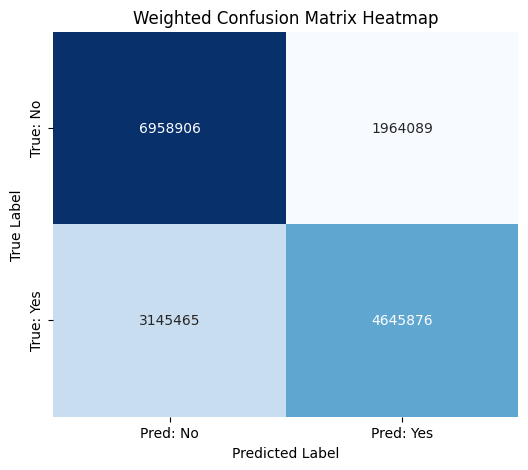

In [ ]:
evaluate_model_performance(best_rf_selected, X_test_scaled_selected, y_test, w_test)

## Gradient Boosting Classifier

In [420]:
best_gb = load_model("03_best_gb.pkl")

Model loaded from: ..\models\03_best_gb.pkl


In [412]:
# Initialize a Gradient Boosting model
gb = GradientBoostingClassifier(random_state=42)

# Define the hyperparameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],       # Number of boosting stages
    'max_depth': [2, 4, 6],               # Maximum depth of each regression tree
    'learning_rate': [0.01, 0.05, 0.1],   # Learning rate shrinks the contribution of each tree
    'min_samples_split': [5, 10, 20],     # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 3, 5],        # Minimum number of samples required to be at a leaf node
    'subsample': [0.6, 0.8]                # Fraction of samples used for fitting each tree
}

# Initialize GridSearchCV with 5-fold cross-validation and ROC AUC as the evaluation metric
grid_search_gb = GridSearchCV(
    estimator=gb,
    param_grid=param_grid,
    scoring='roc_auc',   # Using ROC AUC as the evaluation metric
    cv=5,                # 5-fold cross-validation
    n_jobs=-1,           # Use all available processors
)

# Fit the model using training data and sample weights
grid_search_gb.fit(X_train_scaled, y_train, sample_weight=w_train)

# Get the best model from GridSearchCV
best_gb = grid_search_gb.best_estimator_

# Predict probabilities (for the positive class) on the test set
y_pred_proba_gb = best_gb.predict_proba(X_test_scaled)[:, 1]

# Evaluate the best model using ROC AUC score (applying sample weights on the test set)
roc_auc_gb = roc_auc_score(y_test, y_pred_proba_gb, sample_weight=w_test)
print("Best Model ROC AUC Score:", roc_auc_gb)

# Display the best hyperparameters found by GridSearchCV
print("Best Hyperparameters:", grid_search_gb.best_params_)


Best Model ROC AUC Score: 0.7396374074991107
Best Hyperparameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 100, 'subsample': 0.8}


||---------------------------------------------------------------------
Weighted ROC AUC Score: 0.7396
||---------------------------------------------------------------------

Weighted Classification Report:
               precision    recall  f1-score   support

       False       0.68      0.84      0.75 8922994.970000016
        True       0.75      0.53      0.62 7791340.720000001

    accuracy                           0.70 16714335.690000016
   macro avg       0.71      0.69      0.69 16714335.690000016
weighted avg       0.71      0.70      0.69 16714335.690000016

||---------------------------------------------------------------------


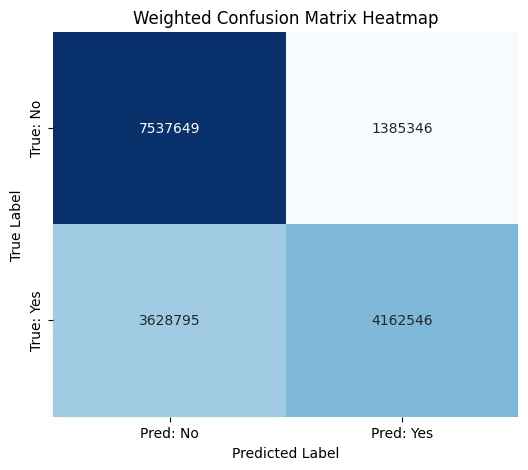

In [413]:
evaluate_model_performance(best_gb, X_test_scaled, y_test, w_test)

In [422]:
save_model(best_gb, "03_best_gb.pkl")

Model saved to: ..\models\03_best_gb.pkl


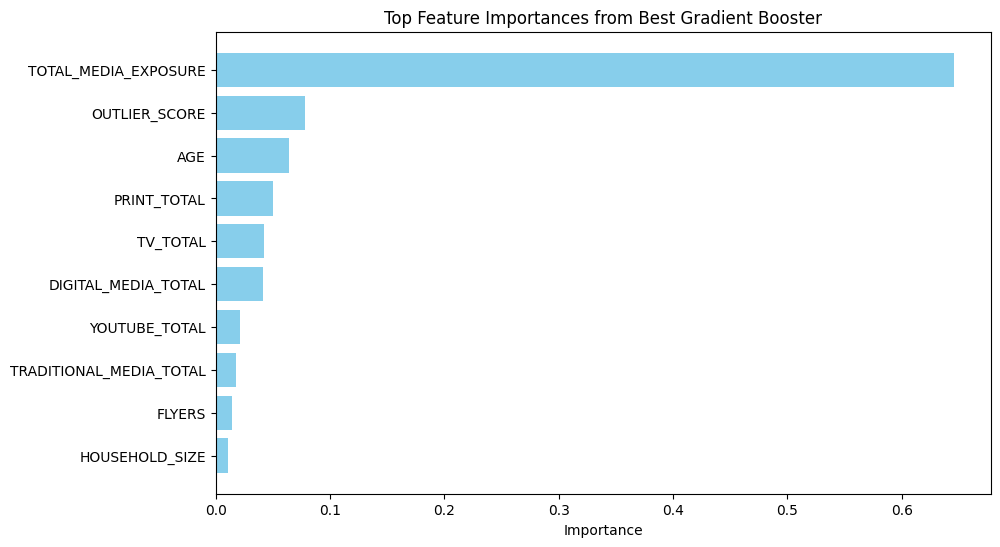

In [450]:
# Get feature importance
importance_df_rf = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_gb.feature_importances_
})

# Sort by importance
importance_df_rf = importance_df_rf.sort_values(by='Importance', ascending=False)

# print(importance_df_rf)

# Plot the top 10 most important features
plt.figure(figsize=(10, 6))
plt.barh(importance_df_rf['Feature'][:10], importance_df_rf['Importance'][:10], color='skyblue')
plt.xlabel('Importance')
plt.title('Top Feature Importances from Best Gradient Booster')
plt.gca().invert_yaxis()  # Invert the y-axis to display the most important features at the top
plt.show()

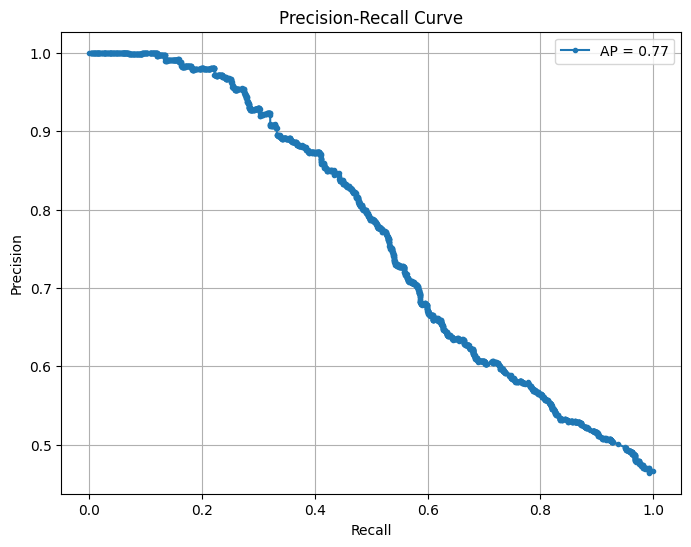

In [451]:
# Example usage:
plot_precision_recall_curve(best_gb, X_test_scaled, y_test, w_test)

### SVM

Support Vector classifier did the best but wit hthe application of sample weights it is just way too slow for me to be able to run it in a reasonable timeframe

In [48]:
# # Initialize the SVM model with probability estimation
# svm_model = SVC(probability=True, kernel="linear", random_state=42)

# # Fit the model with sample weights
# svm_model.fit(X_train_scaled_selected, y_train, sample_weight=w_train)

# # Predict probabilities (probability of Purchase = 1)
# y_pred_proba = svm_model.predict_proba(X_test_scaled)[:, 1]  # Probability of positive class (Purchase = 1)

# # Evaluate model (using ROC AUC score)
# print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba, sample_weight=w_test))

In [49]:
# # Define the hyperparameter grid for tuning SVM
# param_grid = {
#     'C': [0.1, 1, 10, 100],  # Regularization parameter
#     'kernel': ['linear', 'rbf'],  # Kernel types
#     'gamma': ['scale', 'auto', 0.1, 1],  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
#     'degree': [3, 4, 5],  # Degree of the polynomial kernel (only relevant for 'poly')
#     'class_weight': ['balanced'],  # Handle class imbalance
# }

# # Initialize the SVM model
# svm_model = SVC(probability=True, random_state=42)

# # Initialize GridSearchCV
# grid_search_svm = GridSearchCV(
#     estimator=svm_model,
#     param_grid=param_grid,
#     scoring='roc_auc',  # Use ROC AUC as the evaluation metric
#     cv=5,  # 5-fold cross-validation
#     n_jobs=-1,  # Use all available processors
# )

# # Fit the model with training data and sample weights
# grid_search_svm.fit(X_train_scaled, y_train, sample_weight=w_train)

# # Get the best model from GridSearchCV
# best_svm_model = grid_search_svm.best_estimator_

# # Predict probabilities on the test set
# y_pred_proba_svm = best_svm_model.predict_proba(X_test_scaled)[:, 1]

# # Evaluate the best model using ROC AUC score
# roc_auc_svm = roc_auc_score(y_test, y_pred_proba_svm, sample_weight=w_test)
# print("Best SVM Model ROC AUC Score:", roc_auc_svm)

# # Display the best hyperparameters found by GridSearchCV
# print("Best Hyperparameters for SVM:", grid_search_svm.best_params_)